# STUDY CASE | Sakila film rentals

## 01 - Problem (case study)

### Data Description

Data provided in a csv table through a SQL query from our Sakila database with the following features:

* Number of rows: 1521
* Number of columns: 12 <br>
<br>
* Number of numerical variables: 11
* Numbre of categorical/non-numerical variables: 1

## 02 - Goal

The objective of this data is to build a model able to predict wether a film will be rented in the following month taking into account multiple variables that have been initially selected as relevant. Given the nature of the task, we will use logistic regression to accomplish our goal. 

## 03 - Prepare Notebook

In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

········


In [2]:
# To make run all you ask in one cell, not only the last required
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 04 - Get Data through SQL Queries

In [3]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT film_id, COUNT(DISTINCT inventory_id) AS amount_of_copies, COUNT(rental_id) AS times_rented, store_id, release_year, language_id, rental_duration, rental_rate, length, replacement_cost, rating,
CASE
WHEN r.rental_date BETWEEN '2005-08-01' AND '2005-08-31' THEN 1
ELSE 0
END AS rented_august
FROM rental r
LEFT JOIN inventory
USING(inventory_id)
LEFT JOIN film
USING(film_id)
WHERE r.rental_date BETWEEN '2005-01-01' AND '2005-12-31'
GROUP BY film_id, store_id, release_year, language_id, rental_duration, rental_rate, length, replacement_cost, rating;'''


In [25]:
data = pd.read_sql_query(query, engine)
data.head(60)
data.shape
numerical = data.select_dtypes(np.number)
categorical = data.select_dtypes(np.object)
numerical.shape
categorical.shape

,film_id,amount_of_copies,times_rented,store_id,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,rented_august
0,1,4,12,1,2006,1,6,0.99,86,20.99,PG,1
1,1,3,11,2,2006,1,6,0.99,86,20.99,PG,0
2,2,3,6,2,2006,1,3,4.99,48,12.99,G,1
3,3,4,12,2,2006,1,7,2.99,50,18.99,NC-17,1
4,4,4,13,1,2006,1,5,2.99,117,26.99,G,0
5,4,3,9,2,2006,1,5,2.99,117,26.99,G,0
6,5,3,11,2,2006,1,6,2.99,130,22.99,G,1
7,6,3,11,1,2006,1,3,2.99,169,17.99,PG,0
8,6,3,10,2,2006,1,3,2.99,169,17.99,PG,1
9,7,2,6,1,2006,1,6,4.99,62,28.99,PG-13,1


(1521, 12)

(1521, 11)

(1521, 1)

In [5]:
data.to_csv('C:/Student/IRONHACK/Week3/D4/Labs/lab-predictions-logistic-regression/final_table.csv')

## 05 - Cleaning/Wrangling/EDA

In [6]:
# Open file and show types 
data.dtypes

film_id               int64
amount_of_copies      int64
times_rented          int64
store_id              int64
release_year          int64
language_id           int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
rented_august         int64
dtype: object

In [7]:
numerical = data.select_dtypes(np.number)
categorical = data.select_dtypes(np.object)
numerical.describe()

,film_id,amount_of_copies,times_rented,store_id,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rented_august
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.0,1521.0,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,501.905325,3.011177,10.428665,1.500986,2006.0,1.0,4.929652,2.958442,115.115713,20.193156,0.357659
std,288.045040,0.823507,3.429219,0.500163,0.0,0.0,1.409898,1.641262,40.013498,6.063709,0.479469
min,1.000000,2.000000,3.000000,1.000000,2006.0,1.0,3.000000,0.990000,46.000000,9.990000,0.000000
25%,255.000000,2.000000,8.000000,1.000000,2006.0,1.0,4.000000,0.990000,81.000000,14.990000,0.000000
50%,500.000000,3.000000,10.000000,2.000000,2006.0,1.0,5.000000,2.990000,114.000000,20.990000,0.000000
75%,750.000000,4.000000,13.000000,2.000000,2006.0,1.0,6.000000,4.990000,148.000000,24.990000,1.000000
max,1000.000000,4.000000,20.000000,2.000000,2006.0,1.0,7.000000,4.990000,185.000000,29.990000,1.000000


#### Data cleaning and formating

In [8]:
# Drop variables that have std = 0 and film_id because is not relevant for our model
data.drop(['language_id','release_year','film_id'], axis=1, inplace=True)
data.head()

,amount_of_copies,times_rented,store_id,rental_duration,rental_rate,length,replacement_cost,rating,rented_august
0,4,12,1,6,0.99,86,20.99,PG,1
1,3,11,2,6,0.99,86,20.99,PG,0
2,3,6,2,3,4.99,48,12.99,G,1
3,4,12,2,7,2.99,50,18.99,NC-17,1
4,4,13,1,5,2.99,117,26.99,G,0


In [9]:
# Convert numerical to object
data = data.astype({'store_id':'object'})
data.dtypes

amount_of_copies      int64
times_rented          int64
store_id             object
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
rented_august         int64
dtype: object

#### Identify again numerical and categorical variables

In [10]:
numerical = data.select_dtypes(np.number)
categorical = data.select_dtypes(np.object)
numerical.shape
categorical.shape

(1521, 7)

(1521, 2)

In [11]:
numerical.describe()

,amount_of_copies,times_rented,rental_duration,rental_rate,length,replacement_cost,rented_august
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,3.011177,10.428665,4.929652,2.958442,115.115713,20.193156,0.357659
std,0.823507,3.429219,1.409898,1.641262,40.013498,6.063709,0.479469
min,2.000000,3.000000,3.000000,0.990000,46.000000,9.990000,0.000000
25%,2.000000,8.000000,4.000000,0.990000,81.000000,14.990000,0.000000
50%,3.000000,10.000000,5.000000,2.990000,114.000000,20.990000,0.000000
75%,4.000000,13.000000,6.000000,4.990000,148.000000,24.990000,1.000000
max,4.000000,20.000000,7.000000,4.990000,185.000000,29.990000,1.000000


#### Check NaN values

In [12]:
# Check NaN values
data.isnull().values.sum()
# Drop NaN values
# data.dropna(inplace=True)

0

## 06 - Processing Data

#### Data visualization to understand the distribution of the variables

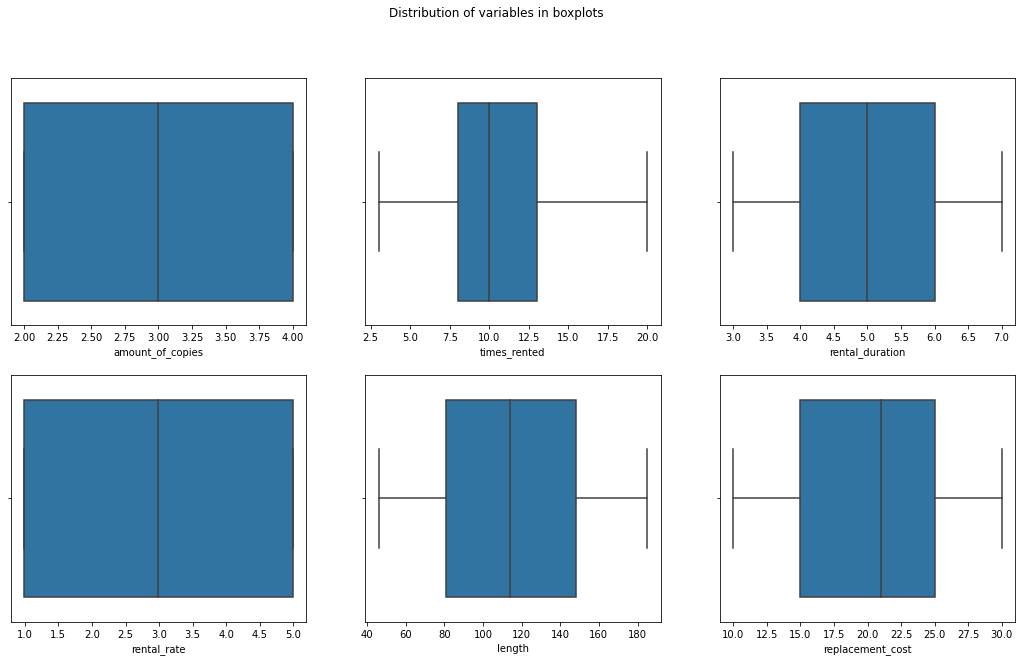

In [13]:
fig, axes = plt.subplots(2,3,  figsize=(18, 10))

fig.suptitle('Distribution of variables in boxplots')

sns.boxplot(ax=axes[0, 0],data= data, x= 'amount_of_copies')
sns.boxplot(ax=axes[0, 1],data= data, x= 'times_rented' )
sns.boxplot(ax=axes[0, 2],data= data, x= 'rental_duration' )
sns.boxplot(ax=axes[1, 0],data= data, x= 'rental_rate')
sns.boxplot(ax=axes[1, 1],data= data, x= 'length')
sns.boxplot(ax=axes[1, 2],data= data, x= 'replacement_cost');

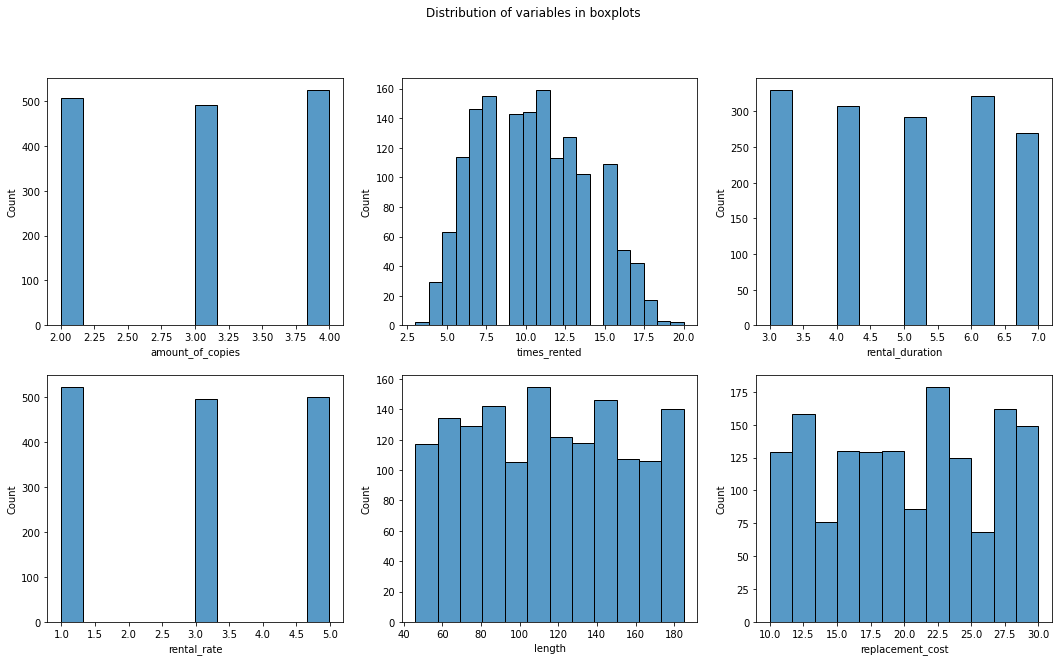

In [14]:
fig, axes = plt.subplots(2,3,  figsize=(18, 10))

fig.suptitle('Distribution of variables in boxplots')

sns.histplot(ax=axes[0, 0],data= data, x= 'amount_of_copies')
sns.histplot(ax=axes[0, 1],data= data, x= 'times_rented' )
sns.histplot(ax=axes[0, 2],data= data, x= 'rental_duration' )
sns.histplot(ax=axes[1, 0],data= data, x= 'rental_rate')
sns.histplot(ax=axes[1, 1],data= data, x= 'length')
sns.histplot(ax=axes[1, 2],data= data, x= 'replacement_cost');

<blockquote><b>Given the uniformity found in the distribution and scale of the numerical variables, no standarisation/normalisation will be applied.</b>.</blockquote>

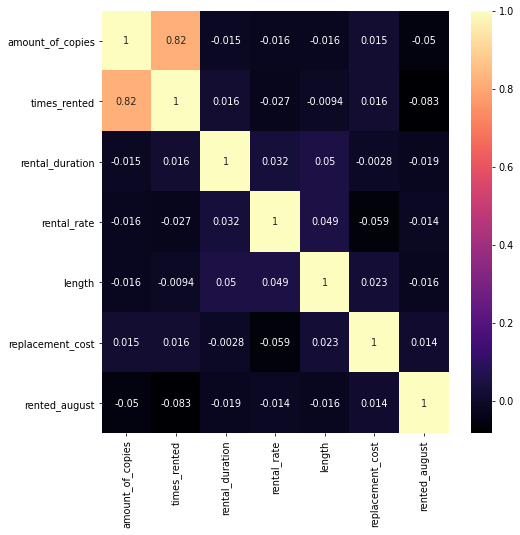

In [15]:
# check for multicollinearity
corr_matrix = numerical.corr()
corr_matrix;

plt.figure(figsize= (8,8), dpi= 70)
corr_matrix = numerical.corr()
sns.heatmap(corr_matrix, annot=True, cmap= 'magma');

In [16]:
# Given the multicollinearity found between amount of copies and times rented, we will drop one of them from the numerical variables

numerical.drop(['amount_of_copies'], axis=1, inplace=True)

C:\Users\besca\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Manage categorical variables

In [17]:
categorical.head()

,store_id,rating
0,1,PG
1,2,PG
2,2,G
3,2,NC-17
4,1,G


In [18]:
categories = pd.get_dummies(categorical, columns=['store_id', 'rating'], drop_first=True)
categories.head(2)

,store_id_2,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,1,0,0
1,1,0,1,0,0


#### Separate x and y

In [19]:
# build X and y
y = data['rented_august']
X = np.concatenate((numerical, categories), axis=1)

#### Train, test split

In [20]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 07 - Modeling

In [21]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='ovr').fit(X_train, y_train)

C:\Users\besca\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## 08 - Model Validation

In [22]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.912472647702407

#### Confusion matrix

In [23]:
confusion_matrix(y_test, predictions)

array([[294,   0],
       [ 40, 123]], dtype=int64)

### THINGS WE CAN DO TO IMPROVE THE MODEL

### Check data leakage

### Linear relation on logit

In [ ]:
logits = np.log(1/classification.predict_proba(X)[:,1]-1);

In [ ]:
plt.scatter(logits,X['replacement_cost']);

### Decide over precision/recall
If we have a very risky decision to make (eg. having a disease), we need to prioritise recall

### Oversampling / undersampling
* Undersample if we have big datasets / Oversample if we have smaller datasets
* Alternatives for oversampling without repeating data: clusters / synthetic sample generation (SMOTE)

### Test other algorithms

In [24]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X, y)
predictions_clf = clf.predict(X_test)
clf.score(X_test, y_test)

KNeighborsClassifier()

0.7636761487964989